<a href="https://colab.research.google.com/github/udupa-varun/pyimagesearch_uni/blob/main/augmented_reality/101/opencv_augmented_reality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/opencv-augmented-reality/opencv-augmented-reality.zip
!unzip -qq opencv-augmented-reality.zip
%cd opencv-augmented-reality
%ls -hal

--2022-06-03 12:11:49--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/opencv-augmented-reality/opencv-augmented-reality.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.211.218
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.211.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19165499 (18M) [application/zip]
Saving to: ‘opencv-augmented-reality.zip’

opencv-augmented-re 100%[===================>]  18.28M  22.7MB/s    in 0.8s    

2022-06-03 12:11:50 (22.7 MB/s) - ‘opencv-augmented-reality.zip’ saved [19165499/19165499]

/content/opencv-augmented-reality/opencv-augmented-reality/opencv-augmented-reality/opencv-augmented-reality/opencv-augmented-reality
total 1.2M
drwxr-xr-x 4 root root 4.0K Dec  7  2020 ./
drwxr-xr-x 5 root root 4.0K Jun  3 12:11 ../
drwxr-xr-x 2 root

In [21]:
print("examples:")
%ls -hal examples

print("sources:")
%ls -hal sources

examples:
total 18M
drwxr-xr-x 2 root root 4.0K Nov  4  2020 ./
drwxr-xr-x 4 root root 4.0K Dec  7  2020 ../
-rw-r--r-- 1 root root 6.0M Oct  2  2020 input_01.jpg
-rw-r--r-- 1 root root 5.0M Oct  2  2020 input_02.jpg
-rw-r--r-- 1 root root 6.3M Oct  2  2020 input_03.jpg
sources:
total 208K
drwxr-xr-x 2 root root 4.0K Nov  4  2020 ./
drwxr-xr-x 4 root root 4.0K Dec  7  2020 ../
-rw-r--r-- 1 root root  44K Nov  4  2020 antelope_canyon.jpg
-rw-r--r-- 1 root root  36K Nov  4  2020 jp.jpg
-rw-r--r-- 1 root root 118K Nov  4  2020 squirrel.jpg


In [8]:
# import packages
import argparse

import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

In [22]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to input image containing ArUCo tag")
# ap.add_argument("-s", "--source", required=True,
# 	help="path to input source image that will be put on input")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "image": "examples/input_01.jpg",
    "source": "sources/jp.jpg"
}

In [23]:
# load input image from disk and resize it
print("[INFO] loading images...")
image = cv2.imread(args["image"])
image = imutils.resize(image, width=600)

# grab dimensions
(image_h, image_w) = image.shape[:2]

# load source image from disk
source = cv2.imread(args["source"])

[INFO] loading images...


In [24]:
# load ArUCo dict
print("[INFO] detecting markers...")
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_ARUCO_ORIGINAL)
aruco_params = cv2.aruco.DetectorParameters_create()
(corners, ids, rejected) = cv2.aruco.detectMarkers(
    image,
    aruco_dict,
    parameters=aruco_params
)

# we need 4 corners for the AR technique
if len(corners) != 4:
    print("[INFO] could not find 4 corners, exiting.")

[INFO] detecting markers...


In [25]:
# otherwise, continue
# flatten the IDs
ids = ids.flatten()
# init list of reference points
ref_pts = []

# loop over ids (tl, tr, br, bl)
for i in (923, 1001, 241, 1007):
    # grab index of corner with current ID
    j = np.squeeze(np.where(ids == i))
    corner = np.squeeze(corners[j])
    # append corner (x,y) to list of ref points
    ref_pts.append(corner)

In [26]:
# unpack ArUCo ref points 
(ref_tl, ref_tr, ref_br, ref_bl) = ref_pts
# and use them to define the "destination" transform matrix
dst_mat = [ref_tl[0], ref_tr[1], ref_br[2], ref_bl[3]]
dst_mat = np.array(dst_mat)

# grab dims of source image
(src_h, src_w) = source.shape[:2]
# define transform matrix for "source" (tl, tr, br, bl)
src_mat = np.array([
                    [0, 0], 
                    [src_w, 0],
                    [src_w, src_h],
                    [0, src_h]]
                   )

# compute the homography matrix and warp source image to destination
(H, _) = cv2.findHomography(src_mat, dst_mat)
warped = cv2.warpPerspective(source, H, (image_w, image_h))

In [27]:
# construct a mask for source image
mask = np.zeros((image_h, image_w), dtype="uint8")
cv2.fillConvexPoly(mask, dst_mat.astype("int32"), (255, 255, 255), cv2.LINE_AA)

# optional step to give the source image a black border
# essentially a dilation
rect = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
mask = cv2.dilate(mask, rect, iterations=2)

# create a 3-channel version of the mask by stacking depth-wise
# to allow is to copy the warped source image onto input
mask_scaled = mask.copy() / 255.0
mask_scaled = np.dstack([mask_scaled] * 3)

# copy warped source image onto input image
# multiply warped source and mask
warped_multiplied = cv2.multiply(warped.astype("float"), mask_scaled)
# multiply original input image with mask, giving more weight to areas without mask
image_multiplied = cv2.multiply(image.astype("float"), 1.0 - mask_scaled)
# add results together
output = cv2.add(warped_multiplied, image_multiplied)
output = output.astype("uint8")

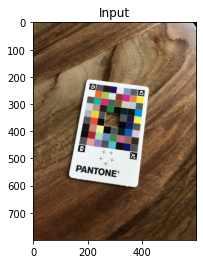

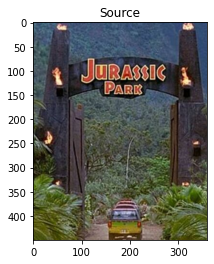

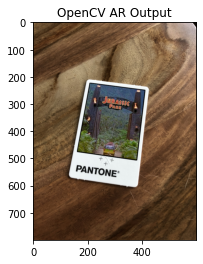

In [28]:
# show input image, source image, output of AR
plt_imshow("Input", image)
plt_imshow("Source", source)
plt_imshow("OpenCV AR Output", output)